In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

np.random.seed(42)

n_A, p_A = 10_000, 0.10
n_B, p_B = 10_000, 0.12

success_A = np.random.binomial(n_A, p_A)
success_B = np.random.binomial(n_B, p_B)

In [5]:
def proportion_ci(successes, n, alpha=0.05):
    p_hat = successes/n
    z = stats.norm.ppf(1-alpha/2)
    se = np.sqrt(p_hat * (1 - p_hat)/n)
    return p_hat, p_hat - z*se, p_hat + z*se

p_A_hat, ci_low_A, ci_high_A = proportion_ci(success_A, n_A)
p_B_hat, ci_low_B, ci_high_B = proportion_ci(success_B, n_B)

results = pd.DataFrame({
    'Variant': ['A', 'B'],
    'Visitors': [n_A, n_B],
    'Conversions': [success_A, success_B],
    'CR (p)': [p_A_hat, p_B_hat],
    'CI Lower (95%)': [ci_low_A, ci_low_B],
    'CI Upper (95%)': [ci_high_A, ci_high_B],
})
print(results)

  Variant  Visitors  Conversions  CR (p)  CI Lower (95%)  CI Upper (95%)
0       A     10000          973  0.0973        0.091491        0.103109
1       B     10000         1134  0.1134        0.107185        0.119615


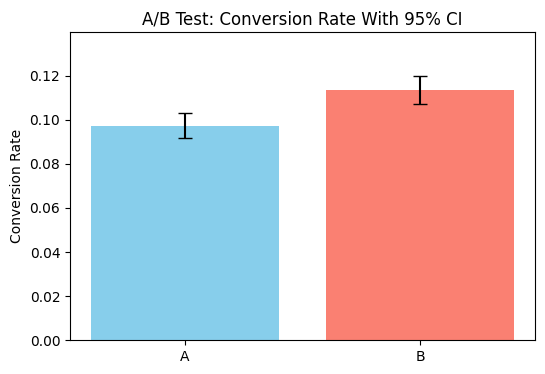

In [9]:
plt.figure(figsize=(6,4))
plt.bar(
    results['Variant'],
    results['CR (p)'],
    yerr = [
        results['CR (p)'] - results['CI Lower (95%)'],
        results['CI Upper (95%)'] - results['CR (p)']
    ],
    capsize = 5,
    color = ['skyblue', 'salmon']
)
plt.ylabel('Conversion Rate')
plt.title('A/B Test: Conversion Rate With 95% CI')
plt.ylim(0, max(results['CI Upper (95%)']) + 0.02)
plt.show()

In [10]:
count = np.array([success_B, success_A])
nobs = np.array([n_B, n_A])

z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')
print(f"Z-Statistic: {z_stat:.3f}")
print(f"P-Value: {p_value:.3f}")

if p_value < 0.05:
    print("-> Reject H0: Variant B has significantly higher conversion rate.")
else:
    print("-> Fail To Reject H0: No significant lift from B over A")

Z-Statistic: 3.708
P-Value: 0.000
-> Reject H0: Variant B has significantly higher conversion rate.


In [22]:
import numpy as np, matplotlib.pyplot as plt, time
from statsmodels.stats.proportion import proportions_ztest
from IPython.display import clear_output
true_p_A, true_p_B = 0.10, 0.12
batch_size = 100
n_batches = 60
n_visits_A = n_visits_B = 0
n_succ_A = n_succ_B = 0
batches = []
p_values = []
lifts = []

Batch 60/60
Variant A: 6000 visits, 588 buys -> CR = 9.800%
Variant B: 6000 visits, 719 buys -> CR = 11.983%
Observed Lift: 2.183%
Z_Stat = 3.84, p_value = 0.0001
-> Significant Lift Detected (P<0.05).


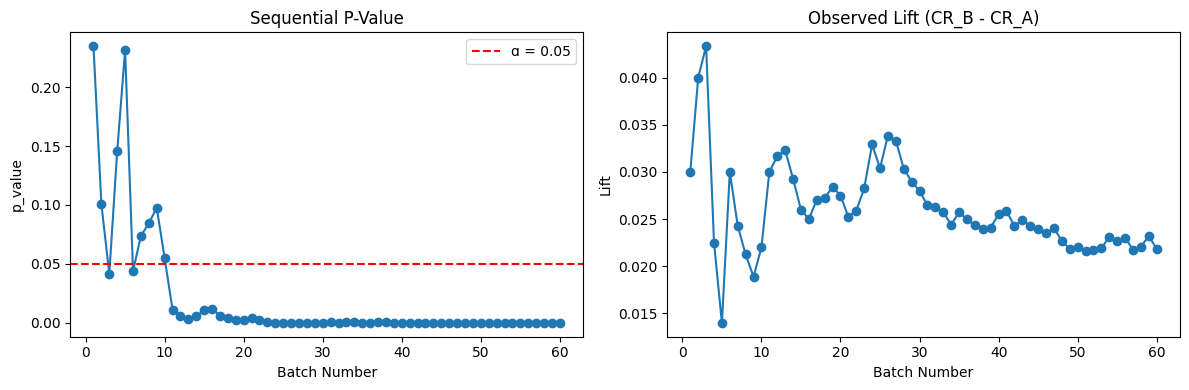

In [23]:
for batch in range(1, n_batches + 1):
    new_A = np.random.binomial(batch_size, true_p_A)
    new_B = np.random.binomial(batch_size, true_p_B)
    
    n_visits_A += batch_size
    n_visits_B += batch_size
    n_succ_A += new_A
    n_succ_B += new_B

    cr_A = n_succ_A / n_visits_A
    cr_B = n_succ_B / n_visits_B
    lift = cr_B - cr_A

    count = np.array([n_succ_B, n_succ_A])
    nobs = np.array([n_visits_B, n_visits_A])
    z_stat, p_val = proportions_ztest(count, nobs, alternative = 'larger')

    batches.append(batch)
    p_values.append(p_val)
    lifts.append(lift)

    clear_output(wait = True)
    print(f"Batch {batch}/{n_batches}")
    print(f"Variant A: {n_visits_A} visits, {n_succ_A} buys -> CR = {cr_A:.3%}")
    print(f"Variant B: {n_visits_B} visits, {n_succ_B} buys -> CR = {cr_B:.3%}")
    print(f"Observed Lift: {lift:.3%}")
    print(f"Z_Stat = {z_stat:.2f}, p_value = {p_val:.4f}")
    if p_val < 0.05:
        print("-> Significant Lift Detected (P<0.05).")
    else:
        print("-> No Significant Lift Detected.")

    fig, axes = plt.subplots(1,2, figsize = (12,4))
    axes[0].plot(batches, p_values, '-o')
    axes[0].axhline(0.05, color = 'red', linestyle='--', label = 'ɑ = 0.05')
    axes[0].set_title('Sequential P-Value')
    axes[0].set_xlabel('Batch Number')
    axes[0].set_ylabel('p_value')
    axes[0].legend()

    axes[1].plot(batches, lifts, '-o')
    axes[1].set_title('Observed Lift (CR_B - CR_A)')
    axes[1].set_xlabel('Batch Number')
    axes[1].set_ylabel('Lift')

    plt.tight_layout()
    plt.show()

    time.sleep(0.2)